<a href="https://colab.research.google.com/github/ShawnTayNWU/MSDS458/blob/MSDS458/MSDS458_Assignment_03_ExpC_UniDir_NoEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 3

### Analyze AG_NEWS_SUBSET Data <br>

AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004. The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc), information retrieval (ranking, search, etc), xml, data compression, data streaming, and any other non-commercial activity.<br> 

For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html<br> 


The AG's news topic classification dataset is constructed by choosing 4 largest classes (**World**, **Sports**, **Business**, and **Sci/Tech**) from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600.<br>

Homepage: https://arxiv.org/abs/1509.01626<br>

Source code: tfds.text.AGNewsSubset

Versions:

1.0.0 (default): No release notes.
Download size: 11.24 MiB

Dataset size: 35.79 MiB

<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div>

## Import packages 

In [1]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

from timeit import default_timer as timer #import a timer
from datetime import datetime

In [2]:
#tf.get_logger().setLevel('INFO')

In [3]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

### Verify TensorFlow Version and Keras Version

In [4]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.6.0


In [5]:
print("Keras version: ", keras.__version__)

Keras version:  2.6.0


### Functions For Research Assignment 

In [6]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions)))) 

In [7]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [8]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### Mount Google Drive to Colab Environment

In [9]:
#from google.colab import drive
#drive.mount('/content/gdrive')

###  TensorFlow Datasets Information<br>
<div class="alert alert-block alert-info">
    <b> ag_news_subset</b><br>
    See https://www.tensorflow.org/datasets/catalog/ag_news_subset
    </div>

Get all the words in the documents (as well as the number of words in each document) by using the encoder to get the indices associated with each token and then translating the indices to tokens. But first we need to get the "unpadded" new articles so that we can get their length.

In [10]:
#register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# https://www.tensorflow.org/datasets/splits
# The full `train` and `test` splits, interleaved together.
ri = tfds.core.ReadInstruction('train') + tfds.core.ReadInstruction('test')
dataset_all, info = tfds.load('ag_news_subset', with_info=True,  split=ri, as_supervised=True)

2021-11-05 17:46:15.977527: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 17:46:16.196224: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 17:46:16.196889: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
I1105 17:46:16.197645 139776672991104 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
2021-11-05 17:46:16.206589: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-11-05 17

###  Exploratory Analysis AG News Subset

**Get information about the ag_news_subset dataset. We combined the training and test data for a total of 127,600 news articles.**

In [11]:
print(info)

tfds.core.DatasetInfo(
    name='ag_news_subset',
    version=1.0.0,
    description='AG is a collection of more than 1 million news articles.
News articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.
ComeToMyHead is an academic news search engine which has been running since July, 2004.
The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc),
information retrieval (ranking, search, etc), xml, data compression, data streaming,
and any other non-commercial activity.
For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .

The AG's news topic classification dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the dataset above.
It is used as a text classification benchmark in the following paper:
Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advanc

In [12]:
tfds.as_dataframe(dataset_all.take(10),info)

,description,label
0,"AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.",3 (Sci/Tech)
1,Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season.,1 (Sports)
2,"President Bush #39;s quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.",2 (Business)
3,"Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.",3 (Sci/Tech)
4,"London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.",1 (Sports)
5,TOKYO - Sony Corp. is banking on the \$3 billion deal to acquire Hollywood studio Metro-Goldwyn-Mayer Inc...,0 (World)
6,"Giant pandas may well prefer bamboo to laptops, but wireless technology is helping researchers in China in their efforts to protect the engandered animals living in the remote Wolong Nature Reserve.",3 (Sci/Tech)
7,"VILNIUS, Lithuania - Lithuania #39;s main parties formed an alliance to try to keep a Russian-born tycoon and his populist promises out of the government in Sunday #39;s second round of parliamentary elections in this Baltic country.",0 (World)
8,Witnesses in the trial of a US soldier charged with abusing prisoners at Abu Ghraib have told the court that the CIA sometimes directed abuse and orders were received from military command to toughen interrogations.,0 (World)
9,"Dan Olsen of Ponte Vedra Beach, Fla., shot a 7-under 65 Thursday to take a one-shot lead after two rounds of the PGA Tour qualifying tournament.",1 (Sports)


### Review Labels (Categories) 

In [13]:
print(f'There are {info.features["label"].num_classes} classes in the dataset.')
print(f'The class names are {info.features["label"].names}')

There are 4 classes in the dataset.
The class names are ['World', 'Sports', 'Business', 'Sci/Tech']


In [14]:
# classes dictionary
categories =dict(enumerate(info.features["label"].names))
categories

{0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

The 127,600 news articles are evenly distributed among the 4 categories

In [15]:
train_categories = [categories[label] for label in dataset_all.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Sci/Tech', 31900), ('Sports', 31900), ('Business', 31900), ('World', 31900)]

### Preprocessing Data Create Input Pipeline

In [16]:
# register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# Example Approaches to Split Data Set
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:]','test[:1000]', 'test[1000:]'],
dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test[:]'],
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:114000]','train[114000:]', 'test[:]'],
                          as_supervised=True)
train_dataset, validation_dataset, test_dataset = dataset
# train_dataset, test_dataset = dataset['train'],dataset['test']

2021-11-05 17:47:16.794496: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 17:47:16.802515: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 17:47:16.803126: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
I1105 17:47:16.803775 140263056983936 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
I1105 17:47:16.804473 140263056983936 dataset_info.py:361] Load dataset info from /root/tensorflow_datasets/ag_news_subset/1.0.0
I1105 17:47:16.805606 140263056983936 download_and_prepare.py:138] download_and_prep

In [17]:
####  Dataset Splits (Training, Test, Validation)
#### .8934 Training, .0470 Test, .0596 Validation

In [18]:
len(train_dataset),len(validation_dataset),len(test_dataset) 
# len(train_dataset),len(test_dataset) 

(114000, 6000, 7600)

### Review Distribution of Categorical Labels for the 114000 training data (news articles)

In [19]:
from collections import Counter
train_categories = [categories[label] for label in train_dataset.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Business', 28531), ('Sports', 28495), ('World', 28491), ('Sci/Tech', 28483)]

Review Example with Interger Label(text, label pairs):

Review Example with Interger Label Encoded Classification(text, label pairs):

In [20]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('class: ', categories[label.numpy()])

text:  b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
class:  Sci/Tech


#### Preprocessing Shuffle Data for Training and Create Batches of `(text, label)` pairs:

In [21]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [22]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [23]:
for example, label in train_dataset.take(2):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'A few years ago, Ichiro Suzuki spent three days on his own wandering around the Hall of Fame, hoping to learn about the history of baseball in America.'
 b'SHANGHAI (Ticker) - Third seed Guillermo Canas of Argentina became the first seeded player to reach the second round of the Heineken Open Shanghai.'
 b'Sanath Jayasuriya took five for 17 to lead Sri Lanka to an emphatic 119-run win the triangular tournament final on Saturday and keep Pakistan waiting for their first one-day title at home.']

labels:  [1 1 1]
texts:  [b' NEW YORK (Reuters) - Software maker Computer Associates  &lt;A HREF="http://www.investor.reuters.com/FullQuote.aspx?ticker=CA.N target=/stocks/quickinfo/fullquote"&gt;CA.N&lt;/A&gt; on Wednesday said it would cut 800 jobs, or 5 percent of  its work force, to pare costs amid stiff competition in  software and services.'
 b"AP - The San Francisco Giants and catcher Mike Matheny agreed to a  #36;10.5 million three-year contract Monday, the latest move to upgr

In [24]:
for example, label in train_dataset.take(2):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', [categories[n] for n in label.numpy()[:3]])
  print()

texts:  [b'Bad weather forces the US to cancel the first full flight test of its national missile defence system in nearly two years.'
 b'BEIJING: China has given the green signal for direct investment of insurance capital in the stock market under strict supervision, the State media reported today.'
 b'Millions of tons of sediment-heavy water are being sent through the Grand Canyon in a bid to help local wildlife.']

labels:  ['Sci/Tech', 'Business', 'Sci/Tech']

texts:  [b"Jennifer Canada knew she was entering a boy's club when she enrolled in Southern Methodist University's Guildhall school of video-game making."
 b"AP - San Francisco cornerback Ahmed Plummer, who hasn't played since Oct. 17, was placed on injured reserve Tuesday because of bulging disc in his neck."
 b'KHARTOUM, Aug 18 (Reuters) - The United Nations said on Wednesday it was very concerned by Sudan #39;s lack of practical progress in bringing security to Darfur, where more than a million people have fled their homes

## Create the Text Encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:
The processing of each sample contains the following steps:

    standardize each sample (usually lowercasing + punctuation stripping)
    split each sample into substrings (usually words)
    recombine substrings into tokens (usually ngrams)
    index tokens (associate a unique int value with each token)
    transform each sample using this index, either into a vector of ints or a dense float vector.


The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [25]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [26]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

1000

In [27]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U14')

Here are the 20 least frequent words.

In [28]:
vocab[-20:]

array(['black', 'turn', 'build', 'countrys', 'advanced', 'whose',
       'crisis', 'create', '23', 'sources', 'body', 'militant', 'hope',
       'event', 'started', 'ready', 'jones', 'lawsuit', 'focus',
       'singapore'], dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):<br>
Default Batch Size = 32

In [29]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  1, 698,   1, 437,  27,   1,   3,   1, 513,  68, 437,   1,   6,
        432,   1,   1,   1, 538,   5,   1, 468,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [ 35, 177, 319,   1,   1,   1,  59,   1,   1, 189, 517, 675,  27,
          1,   8, 630, 587,  44, 220,   5,   1,   1,   6,  24,   1,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  1, 951, 576,  28,   2,  72, 236,  17,   8,  43,  19,  27,   1,
          1,  18, 862,  11,   1,   5,   1,   1,   6,   1,  96,   4, 615,
        289,  41,  57,   3,  69,  80,  30,   1,  32,   1,   9,   1,   5,
          1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [30]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"Jennifer Canada knew she was entering a boy's club when she enrolled in Southern Methodist University's Guildhall school of video-game making."
Round-trip:  [UNK] canada [UNK] she was [UNK] a [UNK] club when she [UNK] in southern [UNK] [UNK] [UNK] school of [UNK] making                                   

Original:  b"AP - San Francisco cornerback Ahmed Plummer, who hasn't played since Oct. 17, was placed on injured reserve Tuesday because of bulging disc in his neck."
Round-trip:  ap san francisco [UNK] [UNK] [UNK] who [UNK] [UNK] since oct 17 was [UNK] on injured reserve tuesday because of [UNK] [UNK] in his [UNK]                               

Original:  b'KHARTOUM, Aug 18 (Reuters) - The United Nations said on Wednesday it was very concerned by Sudan #39;s lack of practical progress in bringing security to Darfur, where more than a million people have fled their homes for fear of militia ...'
Round-trip:  [UNK] aug 18 reuters the united nations said on wednesday it wa

## Create the model: Single Layer Unidirectional RNN with LTSM (Experiment C1U)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

1. The first layer is the `encoder`, which converts the text to a sequence of token indices.

2. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

3. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage to a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

1. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


<div class="alert alert-block alert-info">
    <b>tf.keras.layers.Bidirectional</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
    </div>

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/BidirectionalRNN.png?raw=1">

In [31]:
from keras import backend as K
K.clear_session()

num_classes = 4
model = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.LSTM(64,activation='tanh', recurrent_activation='sigmoid')
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

<div class="alert alert-block alert-success"> 
Please note that we choose to Keras sequential model here since all the layers in the model only have single input and produce single output. </div>

<div class="alert alert-block alert-info"> 
<b>tf.keras.Model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/Model
</div>  

## Compile Model: Single Layer Unidirectional RNN with LTSM (Experiment C1U)

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [32]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](../../guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [33]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


## Train the model: Single Layer Unidirectional RNN with LTSM (Experiment C1U)

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [34]:
start=datetime.now()

history = model.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

end=datetime.now()
print("Experiment C1U time:", end-start) 

Epoch 1/200
1782/1782 [==============================] - 23s 9ms/step - loss: 0.8524 - accuracy: 0.6310 - val_loss: 0.5858 - val_accuracy: 0.7803
Epoch 2/200
1782/1782 [==============================] - 16s 9ms/step - loss: 0.5151 - accuracy: 0.8119 - val_loss: 0.4469 - val_accuracy: 0.8432
Epoch 3/200
1782/1782 [==============================] - 16s 9ms/step - loss: 0.4280 - accuracy: 0.8482 - val_loss: 0.4093 - val_accuracy: 0.8538
Epoch 4/200
1782/1782 [==============================] - 16s 9ms/step - loss: 0.4031 - accuracy: 0.8553 - val_loss: 0.4015 - val_accuracy: 0.8540
Epoch 5/200
1782/1782 [==============================] - 16s 9ms/step - loss: 0.3918 - accuracy: 0.8587 - val_loss: 0.3931 - val_accuracy: 0.8578
Epoch 6/200
1782/1782 [==============================] - 16s 9ms/step - loss: 0.3866 - accuracy: 0.8601 - val_loss: 0.3950 - val_accuracy: 0.8540
Epoch 7/200
1782/1782 [==============================] - 16s 9ms/step - loss: 0.3825 - accuracy: 0.8613 - val_loss: 0.3921 -

In [35]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 1s 5ms/step - loss: 0.4128 - accuracy: 0.8511
Test Loss: 0.4128133952617645
Test Accuracy: 0.8510526418685913


## Plotting Performance Metrics: Single Layer Unidirectional RNN with LTSM (Experiment C1U)

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [36]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.852,0.631,0.586,0.780
1,0.515,0.812,0.447,0.843
2,0.428,0.848,0.409,0.854
3,0.403,0.855,0.402,0.854
4,0.392,0.859,0.393,0.858
5,0.387,0.860,0.395,0.854
6,0.383,0.861,0.392,0.857


In [38]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

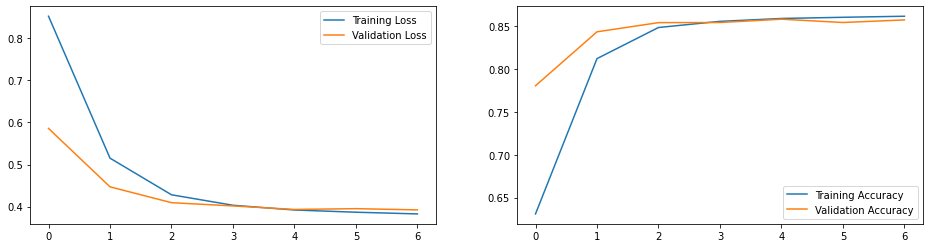

In [39]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Model Architecture Summary: Single Layer unidirectional RNN with LTSM (Experiment C1U)

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 101,444
Trainable params: 101,444
Non-trainable params: 0
_________________________________________________________________


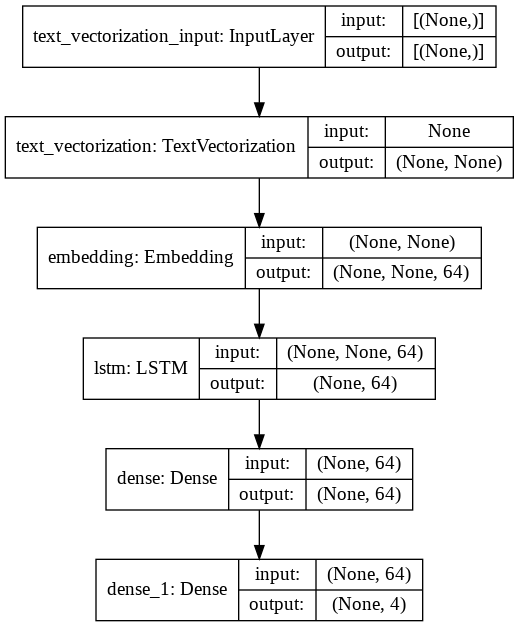

In [41]:
keras.utils.plot_model(model, "BiDirectionalLSTM.png", show_shapes=True)

##Create model by stacking two or more layers: Multi Layer Unidirectional RNN with LTSM (Experiment C2U)


Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional]?raw=1"

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/multilayerBidirectionalLSTM.png?raw=1">

In [42]:
from keras import backend as K
K.clear_session()

model2 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.LSTM(64,activation='tanh', recurrent_activation='sigmoid',  return_sequences=True)
                              ,tf.keras.layers.LSTM(32,activation='tanh', recurrent_activation='sigmoid')
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [43]:
model2.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [44]:
start=datetime.now()

history2 = model2.fit(train_dataset
                    ,epochs=200
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

end=datetime.now()
print("Experiment C2U time:", end-start) 

Epoch 1/200
1782/1782 [==============================] - 32s 15ms/step - loss: 0.5488 - accuracy: 0.7989 - val_loss: 0.4137 - val_accuracy: 0.8630
Epoch 2/200
1782/1782 [==============================] - 24s 14ms/step - loss: 0.4430 - accuracy: 0.8479 - val_loss: 0.4173 - val_accuracy: 0.8568
Epoch 3/200
1782/1782 [==============================] - 24s 14ms/step - loss: 0.4219 - accuracy: 0.8541 - val_loss: 0.3876 - val_accuracy: 0.8667
Epoch 4/200
1782/1782 [==============================] - 24s 14ms/step - loss: 0.4054 - accuracy: 0.8592 - val_loss: 0.4095 - val_accuracy: 0.8625
Epoch 5/200
1782/1782 [==============================] - 24s 14ms/step - loss: 0.3910 - accuracy: 0.8636 - val_loss: 0.3761 - val_accuracy: 0.8656
Experiment C2U time: 0:02:09.521548


In [45]:
test_loss, test_acc = model2.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 1s 6ms/step - loss: 0.3980 - accuracy: 0.8563
Test Loss: 0.39804115891456604
Test Accuracy: 0.8563157916069031


## Plotting Performance Metrics: Multi Layer Unidirectional RNN with LTSM (Experiment C2U)

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [46]:
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [47]:
history2_df=pd.DataFrame(history_dict2)
history2_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.549,0.799,0.414,0.863
1,0.443,0.848,0.417,0.857
2,0.422,0.854,0.388,0.867
3,0.405,0.859,0.410,0.863
4,0.391,0.864,0.376,0.866


In [48]:
losses = history2.history['loss']
accs = history2.history['accuracy']
val_losses = history2.history['val_loss']
val_accs = history2.history['val_accuracy']
epochs = len(losses)

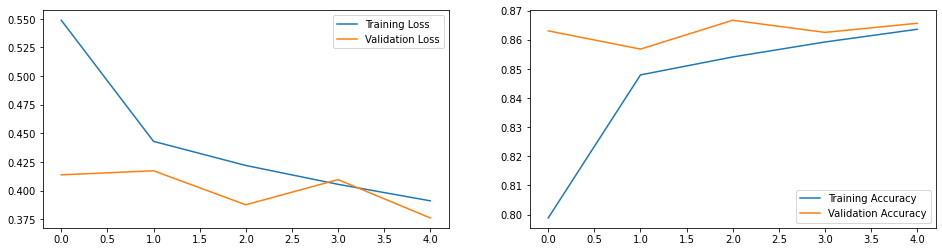

In [49]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [50]:
preds = model2.predict(test_dataset)

In [51]:
preds.shape

(7600, 4)

In [52]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [53]:
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.47%,99.82%,0.16%,3.22%,99.62%,0.51%,2.27%,9.33%,95.57%,0.64%,99.80%,1.73%,0.71%,83.14%,99.68%
Sports,99.51%,0.01%,0.01%,96.68%,0.01%,0.11%,97.57%,89.11%,0.11%,0.02%,0.00%,0.95%,0.00%,0.86%,0.01%
Business,0.01%,0.09%,3.36%,0.05%,0.15%,22.96%,0.08%,0.24%,1.18%,58.57%,0.08%,1.46%,97.14%,3.50%,0.15%
Sci/Tech,0.01%,0.09%,96.48%,0.05%,0.23%,76.41%,0.08%,1.32%,3.14%,40.76%,0.11%,95.85%,2.15%,12.50%,0.17%


#### Model Architecture Summary: Multi Layer Unidirectional RNN with LTSM (Experiment C2U)

In [54]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          33024     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2

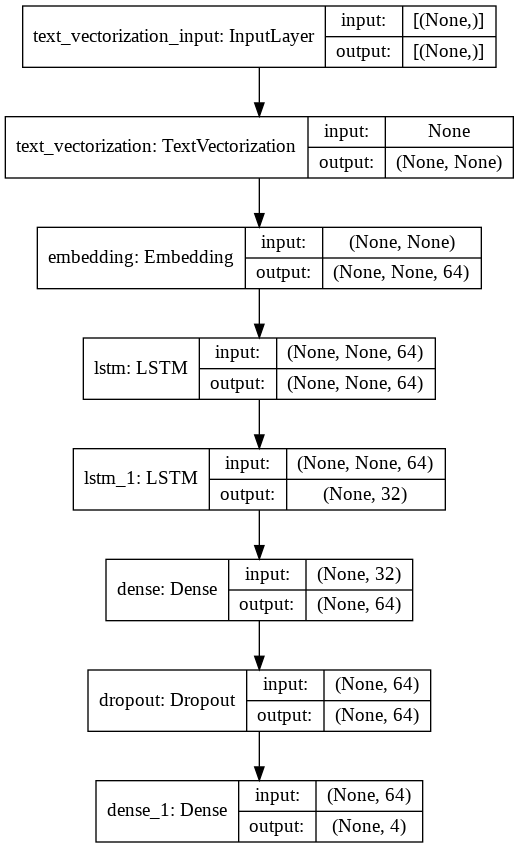

In [55]:
keras.utils.plot_model(model2, "2Layer_BiDirectionalLSTM.png", show_shapes=True)

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](../../guide/keras/rnn.ipynb).


## Create the model: Single Layer Unidirectional RNN GRU (Experiment C3U)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

1. The first layer is the `encoder`, which converts the text to a sequence of token indices.

2. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

3. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage to a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

1. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


<div class="alert alert-block alert-info">
    <b>tf.keras.layers.Bidirectional</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
    </div>

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/BidirectionalRNN.png?raw=1">

In [56]:
from keras import backend as K
K.clear_session()

num_classes = 4
model3 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.GRU(64,activation='tanh', recurrent_activation='sigmoid')
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

<div class="alert alert-block alert-success"> 
Please note that we choose to Keras sequential model here since all the layers in the model only have single input and produce single output. </div>

<div class="alert alert-block alert-info"> 
<b>tf.keras.Model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/Model
</div>  

## Compile Model: Single Layer Unidirectional RNN GRU (Experiment C3U)

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [57]:
model3.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](../../guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [58]:
print([layer.supports_masking for layer in model3.layers])

[False, True, True, True, True]


## Train the model: Single Layer Unidirectional RNN GRU (Experiment C3U)

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [59]:
start=datetime.now()

history3 = model3.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

end=datetime.now()
print("Experiment C3U time:", end-start) 

Epoch 1/200
1782/1782 [==============================] - 20s 9ms/step - loss: 0.8806 - accuracy: 0.6076 - val_loss: 0.5275 - val_accuracy: 0.8105
Epoch 2/200
1782/1782 [==============================] - 15s 8ms/step - loss: 0.4827 - accuracy: 0.8275 - val_loss: 0.4750 - val_accuracy: 0.8358
Epoch 3/200
1782/1782 [==============================] - 15s 9ms/step - loss: 0.4555 - accuracy: 0.8370 - val_loss: 0.4585 - val_accuracy: 0.8387
Epoch 4/200
1782/1782 [==============================] - 15s 8ms/step - loss: 0.4465 - accuracy: 0.8396 - val_loss: 0.4498 - val_accuracy: 0.8432
Epoch 5/200
1782/1782 [==============================] - 15s 9ms/step - loss: 0.4418 - accuracy: 0.8419 - val_loss: 0.4466 - val_accuracy: 0.8430
Epoch 6/200
1782/1782 [==============================] - 15s 8ms/step - loss: 0.4377 - accuracy: 0.8429 - val_loss: 0.4453 - val_accuracy: 0.8410
Experiment C3U time: 0:01:36.041621


In [60]:
test_loss, test_acc = model3.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 1s 5ms/step - loss: 0.4593 - accuracy: 0.8341
Test Loss: 0.45929837226867676
Test Accuracy: 0.8340789675712585


## Plotting Performance Metrics: Single Layer Unidirectional RNN GRU (Experiment C3U)

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [61]:
history_dict3 = history3.history
history_dict3.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [62]:
history3_df=pd.DataFrame(history_dict3)
history3_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.881,0.608,0.527,0.811
1,0.483,0.827,0.475,0.836
2,0.456,0.837,0.458,0.839
3,0.447,0.840,0.450,0.843
4,0.442,0.842,0.447,0.843
5,0.438,0.843,0.445,0.841


In [63]:
losses = history3.history['loss']
accs = history3.history['accuracy']
val_losses = history3.history['val_loss']
val_accs = history3.history['val_accuracy']
epochs = len(losses)

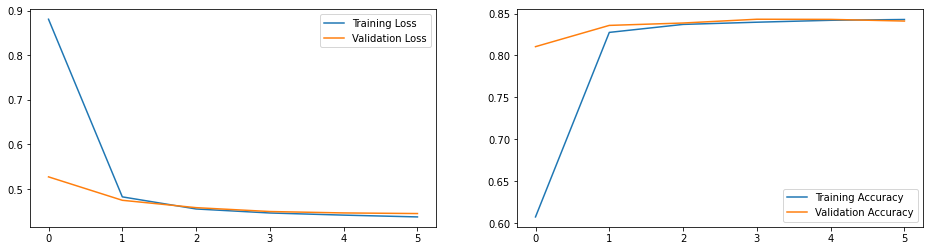

In [64]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Model Architecture Summary: Single Layer Unidirectional RNN GRU (Experiment C3U)

In [65]:
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
gru (GRU)                    (None, 64)                24960     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 93,380
Trainable params: 93,380
Non-trainable params: 0
_________________________________________________________________


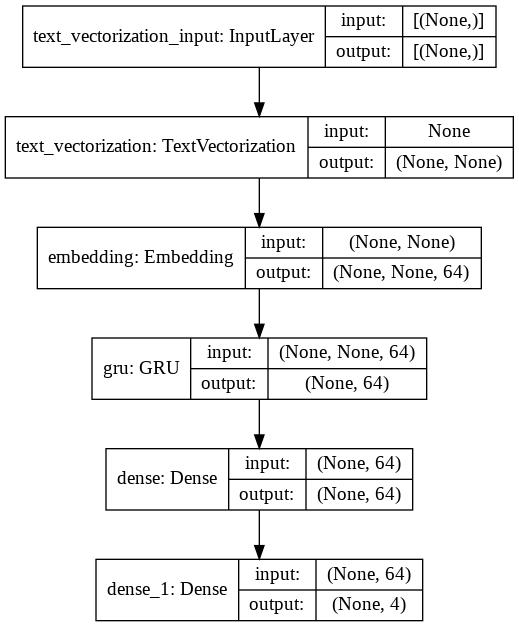

In [66]:
keras.utils.plot_model(model3, "BiDirectionalGRU.png", show_shapes=True)

##Create model: Multi Layer Unidirectional RNN with GRU (Experiment C4U)


Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional]?raw=1"

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/multilayerBidirectionalLSTM.png?raw=1">

In [67]:
from keras import backend as K
K.clear_session()

model4 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.GRU(64,activation='tanh', recurrent_activation='sigmoid',  return_sequences=True)
                              ,tf.keras.layers.GRU(32,activation='tanh', recurrent_activation='sigmoid')
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [68]:
model4.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [69]:
start=datetime.now()

history4 = model4.fit(train_dataset
                    ,epochs=200
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

end=datetime.now()
print("Experiment C4U time:", end-start) 

Epoch 1/200
1782/1782 [==============================] - 31s 14ms/step - loss: 0.5484 - accuracy: 0.7981 - val_loss: 0.4245 - val_accuracy: 0.8500
Epoch 2/200
1782/1782 [==============================] - 23s 13ms/step - loss: 0.4406 - accuracy: 0.8480 - val_loss: 0.4125 - val_accuracy: 0.8516
Epoch 3/200
1782/1782 [==============================] - 24s 13ms/step - loss: 0.4201 - accuracy: 0.8546 - val_loss: 0.4039 - val_accuracy: 0.8641
Epoch 4/200
1782/1782 [==============================] - 24s 13ms/step - loss: 0.4022 - accuracy: 0.8596 - val_loss: 0.4028 - val_accuracy: 0.8562
Epoch 5/200
1782/1782 [==============================] - 23s 13ms/step - loss: 0.3889 - accuracy: 0.8638 - val_loss: 0.3871 - val_accuracy: 0.8615
Experiment C4U time: 0:02:05.567355


In [70]:
test_loss, test_acc = model4.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 1s 6ms/step - loss: 0.4055 - accuracy: 0.8561
Test Loss: 0.40545424818992615
Test Accuracy: 0.8560526371002197


## Plotting Performance Metrics: Multi Layer Unidirectional RNN with GRU (Experiment C4U)

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [71]:
history_dict4 = history4.history
history_dict4.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [72]:
history4_df=pd.DataFrame(history_dict4)
history4_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.548,0.798,0.425,0.850
1,0.441,0.848,0.412,0.852
2,0.420,0.855,0.404,0.864
3,0.402,0.860,0.403,0.856
4,0.389,0.864,0.387,0.861


In [73]:
losses = history4.history['loss']
accs = history4.history['accuracy']
val_losses = history4.history['val_loss']
val_accs = history4.history['val_accuracy']
epochs = len(losses)

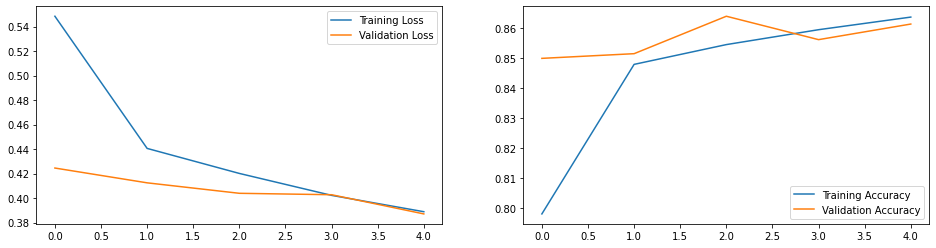

In [74]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [75]:
preds = model4.predict(test_dataset)

In [76]:
preds.shape

(7600, 4)

In [77]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [78]:
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.58%,99.94%,0.08%,2.09%,99.85%,0.35%,1.03%,6.10%,96.61%,2.65%,99.93%,0.34%,2.85%,96.19%,99.85%
Sports,99.41%,0.00%,0.01%,97.89%,0.00%,0.07%,98.92%,93.57%,0.14%,0.04%,0.00%,0.10%,0.00%,0.25%,0.00%
Business,0.01%,0.04%,3.83%,0.01%,0.09%,15.45%,0.02%,0.08%,1.08%,82.15%,0.04%,2.30%,96.79%,1.24%,0.09%
Sci/Tech,0.00%,0.02%,96.08%,0.01%,0.06%,84.12%,0.02%,0.24%,2.17%,15.17%,0.03%,97.26%,0.35%,2.32%,0.06%


#### Model Architecture Summary: Multi Layer Unidirectional RNN with GRU (Experiment C4U)

In [79]:
model4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
gru (GRU)                    (None, None, 64)          24960     
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2

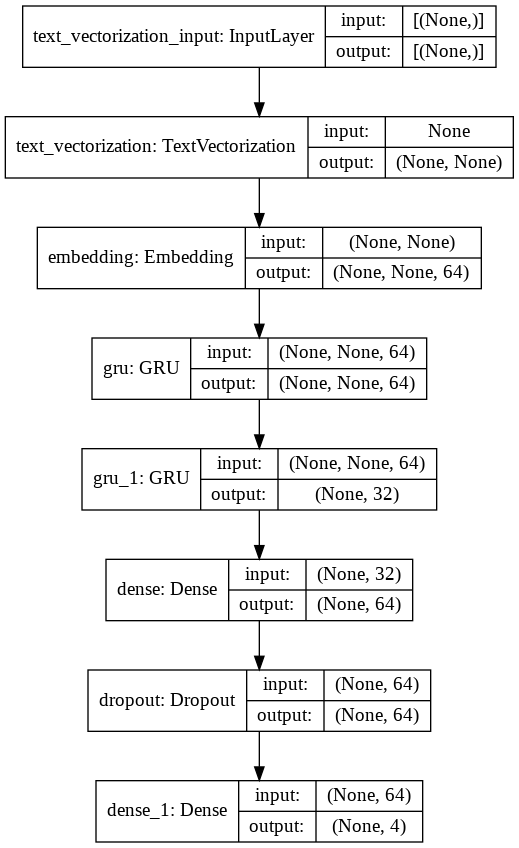

In [80]:
keras.utils.plot_model(model4, "2Layer_BiDirectionalGRU.png", show_shapes=True)

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](../../guide/keras/rnn.ipynb).
